# Cepheids: One Galaxy

- Gabriel Wendell Celestino Rocha
- João Victor Lacerda Aires
- Leonardo Andrade de Almeida

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.collections import PolyCollection, LineCollection

from loguru import logger
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

import numba
import emcee
import corner
from numba import jit, njit


import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic: single plot

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20

def sm_plot(grid = True, dark_background = False, use_tex = False, font_family = 'monospace', font_size = 15, 
            minorticks = True, major_ticks = True, minor_ticks = True, grid_linestyle = ':', grid_color = '0.50', 
            tick_length_minor = 5, tick_width_minor = 1, tick_length_major = 8, tick_width_major = 1, labelsize = 15):
    """
    Function to improve the aesthetics of Matplotlib graphs.
    """
    if dark_background:
        plt.style.use('dark_background')
    
    if grid:
        plt.grid(True, linestyle = grid_linestyle, color = grid_color, zorder = 0)
    else:
        plt.grid(False)
    
    plt.rcParams['text.usetex'] = use_tex
    plt.rcParams['font.family'] = font_family
    plt.rcParams['font.size'] = font_size
    
    if minorticks:
        plt.minorticks_on()
    else:
        plt.minorticks_off()
    
    if minor_ticks:
        plt.tick_params(axis = 'both', which = 'minor', direction = "in", 
                        top = True, right = True, length = tick_length_minor, 
                        width = tick_width_minor, labelsize = labelsize)
    
    if major_ticks:
        plt.tick_params(axis = 'both', which = 'major', direction = "in", 
                        top = True, right = True, length = tick_length_major, 
                        width = tick_width_major, labelsize = labelsize)

- ### **Aesthetics: plot axes**

In [3]:
def sm_plot_mod(ax, grid = True, dark_background = False, use_tex = False, font = 'monospace', font_size = 15, 
                minor_ticks = True, minor_tick_params = True, major_tick_params = True):
    
    if dark_background:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')

    ax.grid(grid, linestyle = ':', color = '0.50')
    
    plt.rcParams['font.family'] = font
    plt.rcParams['font.size'] = font_size
    
    plt.rcParams['text.usetex'] = use_tex
    
    if minor_ticks:
        ax.minorticks_on()
    else:
        ax.minorticks_off()

    if minor_tick_params:
        ax.tick_params(axis = 'both', which = 'minor', direction = "in", 
                       top = True, right = True, length = 5, width = 1, labelsize = font_size)

    if major_tick_params:
        ax.tick_params(axis = 'both', which = 'major', direction = "in", 
                       top = True, right = True, length = 8, width = 1, labelsize = font_size)

---

## 1. Loading data

The data tables were extracted from the article itself and saved in `data` folder.

The master dataframe consists of the union of the two datasets presented above. It is also important to reorganize the data so that it is indexed based on the galaxy analyzed (NGC number). The base-$10\log$ of the period for each Cepheid is also calculated.

In [4]:
data_path = '../data/'
df_path = data_path + 'R11treat.dat'

df = pd.read_csv(df_path, sep = '	', skiprows = 8)
print('DATAFRAME MASTER =D')
display(df)

print('---------------------')
print('  SHAPE =', df.shape)
print('---------------------')

info_path = data_path + 'R11treat_info.txt'

with open(info_path, 'r') as file:
    info = file.read()

print(info)

DATAFRAME MASTER =D


,id,gal,z,dL,M,Merr,m,merr,P,logP,logO_H,bias,Pivot
0,27185,4536,0.006031,25.847143,-7.549763,0.31,24.5123,0.31,13.000,1.113943,-3.46,0.13,1.474125
1,42353,4536,0.006031,25.847143,-6.071363,0.74,25.9907,0.74,13.070,1.116276,-3.03,0.37,1.474125
2,50718,4536,0.006031,25.847143,-7.912863,0.42,24.1492,0.42,13.730,1.137671,-3.36,0.28,1.474125
3,72331,4536,0.006031,25.847143,-7.586963,0.44,24.4751,0.44,13.910,1.143327,-3.19,0.22,1.474125
4,65694,4536,0.006031,25.847143,-7.203863,0.38,24.8582,0.38,14.380,1.157759,-3.10,0.39,1.474125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,29163,4258,0.001494,6.402857,-4.879869,0.57,24.1520,0.57,6.739,0.828595,-3.25,0.38,1.474125
642,34729,4258,0.001494,6.402857,-6.371069,0.50,22.6608,0.50,14.920,1.173769,-3.25,0.00,1.474125
643,89375,4258,0.001494,6.402857,-6.619069,0.45,22.4128,0.45,12.380,1.092721,-3.11,0.42,1.474125
644,246695,4258,0.001494,6.402857,-6.434969,0.40,22.5969,0.40,11.200,1.049218,-3.11,0.49,1.474125


---------------------
  SHAPE = (646, 13)
---------------------

# R11treat.dat
#
# This is a processed and treated version of the Cepheid and redshift datas from R11.
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# Columns:
#      id: the ID of the cepheid
#     gal: the NGC number of the host galaxy
#       z: redshift of the host galaxy
#      dL: the distance computed via Hubble's law
#       M: abs mags M are computed using M = m + 5*log10(dL/Mpc) + 25
#    Merr: abs mags errs are just the mags m errs
#       m: mags m are computed using m = F160W - 0.41*(V_I)
#    merr: mag errs are just those in the F160W mags
#          (errors in V-I were not given in R11)
#       P: period P is in days (errors in the Period were not given)
#    logP: base-10log of the period for each Cepheid
#  logO_H: this is actually log[O/H], not 12 + log[O/H] as in R11
#    bias: this is the crowding bias *already applied* by R11
#
# Notes:
# - cepheid with id 102255 was excluded since its mag err

---

## 2. Model Specification

To address this problem, we need to construct a Probabilistic Graphical Model (PGM) that captures the relationships between the different variables listed. The PGM will help visualize how these variables interact, and the probabilistic expressions will describe the relationships between them.

### 2.1 Drawing the PGM

The PGM will represent the dependencies between the variables. Here's how the nodes and edges should be organized:

### Nodes

1. $m_{ij}^{\text{obs.}}=$ Observed apparent magnitude ;
2. $m_{ij}=$ True apparent magnitude ;
3. $\varepsilon_{ij}=$ Observational uncertainty on the apparent magnitude ;
4. $M_{iji}=$ True absolute magnitude ;
5. $\log_{10}P_{ij}=$ Log period ;
6. $d_{L,i}=$ Luminosity distance to the galaxy ;
7. $a_{i}=$ Intercept parameter of the $(P-L)$ relation ;
8. $b_{i}=$ Slope parameter of the $(P-L)$ relation ;
9. $\sigma_{i}=$ Intrinsic scatter parameter .

**OBS :** The indices $(i,j)$ represent the Cepheid $j^{th}$ in galaxy $i^{th}$, respectively.

### Edges
1. $m_{ij}^{\text{obs.}}=m_{i,j}^{\text{obs.}}\left(m_{ij},\varepsilon_{ij}\right)$ ; 
2. $m_{ij}=m_{ij}\left(M_{ij},d_{L,i},\sigma_{i}\right)$ ; 
3. $M_{ij}=M_{ij}\left(\log_{10}P_{ij},a_{i},b_{i}\right)$ ;

**OBS :** The dependence of $\sigma_{i}$ on $m_{i}$ is necessary to take into account the intrinsic scattering.

The PGM can be visually represented as follows:

```css
    [a_i]        [b_i]        [sigma_i]
      |            |              |
      v            v              v
    [M_ij] ----> [m_ij] ----> [m_ij^obs]
      ^            ^
      |            |
  [log_10 P_ij]   [d_L,i]

```

### 2.2 Writing the Probabilistic Expressions

The basic linear relationship between period and absolute magnitude is given by

$$
M_{ij}=a_{i}+b_{i}\log_{10}\left(P_{ij}\right)+\varepsilon_{ij}\text{ },\quad\text{where:}\quad\varepsilon_{ij}\thicksim\mathcal{N}\left(0,\sigma_{i}\right)
$$

The term $\varepsilon_{ij}$ captures the intrisic scatter.

### Hierarchical Process

1. **For each galaxy** $i$, we have a distribution for $a_{i}$, $b_{i}$ and $\sigma_{i}$ with wide uniform priors.
2. **For each Cepheid** $j$ in galaxy $i$, we model the apparent magnitude $m_{ij}$ in terms of $M_{ij}$ and $d_{L,i}$.

### Computational Implementation

- #### Sample Data

In [5]:
logP = df['logP']
m_obs = df['m']
err_m = df['merr']
dL = df['dL']
M = df['M']

- #### Define the log-likelihood function

In [6]:
def log_likelihood(params, logP, m_obs, err_m, dL):
    a_i, b_i, sigma_i = params
    
    # Theoretical magnitude
    M_ij = a_i + b_i * logP
    m_ij = M_ij + 5 * np.log10(dL) + 25
    
    # Gaussian likelihood with intrinsic scatter
    likelihoods = norm.logpdf(m_obs, loc = m_ij, scale = np.sqrt(err_m**2 + sigma_i**2))
    
    # Return negative log-likelihood for minimization
    return -np.sum(likelihoods)  

- #### Implementation

In [7]:
# Initial guesses for parameters
initial_params = [0, 1, 0.1]

# Minimize the negative log-likelihood
result = minimize(log_likelihood, initial_params, args = (logP, m_obs, err_m, dL), method = 'L-BFGS-B')

# Extract the optimized parameters
a_i_opt, b_i_opt, sigma_i_opt = result.x

# --------------------------------------------------------------------------------------------------------------

# Compute the Hessian matrix (second derivatives of the log-likelihood)
hessian_inv = result.hess_inv.todense()  # Inverse of Hessian matrix

# Standard errors of the parameters are the square roots of the diagonal elements
standard_errors = np.sqrt(np.diag(hessian_inv))

# Calculate the 95% confidence intervals using the normal approximation
confidence_intervals = np.array([
    result.x - 1.96 * standard_errors,
    result.x + 1.96 * standard_errors
]).T

- #### Results

In [8]:
print(f"1) Optimized a_i: {a_i_opt} ± {standard_errors[0]}")
print(f"2) Optimized b_i: {b_i_opt} ± {standard_errors[1]}")
print(f"3) Optimized sigma_i: {sigma_i_opt} ± {standard_errors[2]}")

print("\n95% Confidence Intervals:")
print(f"1) a_i: [{confidence_intervals[0, 0]}, {confidence_intervals[0, 1]}]")
print(f"2) b_i: [{confidence_intervals[1, 0]}, {confidence_intervals[1, 1]}]")
print(f"3) sigma_i: [{confidence_intervals[2, 0]}, {confidence_intervals[2, 1]}]")

1) Optimized a_i: -2.8041024392018623 ± 0.2827244443119007
2) Optimized b_i: -3.063083583619769 ± 0.15806565965643068
3) Optimized sigma_i: 0.7254236426215227 ± 0.02756171544859829

95% Confidence Intervals:
1) a_i: [-3.3582423500531875, -2.249962528350537]
2) b_i: [-3.372892276546373, -2.7532748906931652]
3) sigma_i: [0.67140268034227, 0.7794446049007754]


### Notes

#### 1. Hessian Matrix
The Hessian matrix is a square matrix of second-order partial derivatives of the log-likelihood function with respect to the parameters. The inverse of the Hessian gives an estimate of the covariance matrix of the parameters.

$$
\left(\mathbb{H}_{f}\right)_{ij}=\frac{\partial^{2}f}{\partial x_{i}\partial x_{j}}\iff\mathbb{H}\left[f\left(\bf{x}\right)\right]=\mathbb{J}\left[\nabla f\left(\bf{x}\right)\right]^{T}
$$

`result.hess_inv.todense()` provides the inverse of the Hessian matrix, which we then use to compute the standard errors.

#### 2. Standard Errors
The standard errors of the parameters are the square roots of the diagonal elements of the covariance matrix (`hessian_inv`).

#### 3. Confidence Intervals
The $95\%$ confidence intervals are calculated using the normal approximation:

$$
\text{CI}=\hat{\theta}\pm1.96\times\text{SE}\left(\theta\right)\text{ },
$$
where $\hat{\theta}$ is the estimated parameter and $\text{SE}\left(\theta\right)$ is the standar error.

- #### $\text{PGM Fit} \times \text{Scipy Fit}$

In [9]:
#############
## PGM Fit ##
#############
logP_range = np.linspace(min(logP), max(logP), 100)
M_fit = a_i_opt + b_i_opt * logP_range
# Assuming a constant dL for simplicity
m_fit = M_fit + 5 * np.log10(dL.mean()) + 25  

# Calculate the confidence bounds for the fitted line
m_fit_upper = (a_i_opt + standard_errors[0]) + (b_i_opt + standard_errors[1]) * logP_range
m_fit_lower = (a_i_opt - standard_errors[0]) + (b_i_opt - standard_errors[1]) * logP_range

# --------------------------------------------------------------------------------------------------------------

#############
# Scipy Fit #
#############
def meanfunc(x, a, b):
    return a + b * (x - global_pivot)

param_names = ['a', 'b', 'sigma']
param_labels = [r'$a$', r'$b$', r'$\sigma$']

global_pivot = df['logP'].mean()
df['Pivot'] = global_pivot

xx = np.linspace(df['logP'].min(), df['logP'].max(), len(df['Pivot']))
params, covariance = curve_fit(meanfunc, df['logP'], df['M'], p0 = [0, 0])
a_opt, b_opt = params

param_errors = np.sqrt(np.diag(covariance))
a_std, b_std = param_errors

In [12]:
print('PGM')
print('a_i_opt =', a_i_opt)
print('b_i_opt =', b_i_opt)

print('\nScipy')
print('a_opt =', a_opt)
print('b_opt =', b_opt)

PGM
a_i_opt = -2.8041024392018623
b_i_opt = -3.063083583619769

Scipy
a_opt = -7.2781211776332855
b_opt = -3.117488488241215


- #### Plot

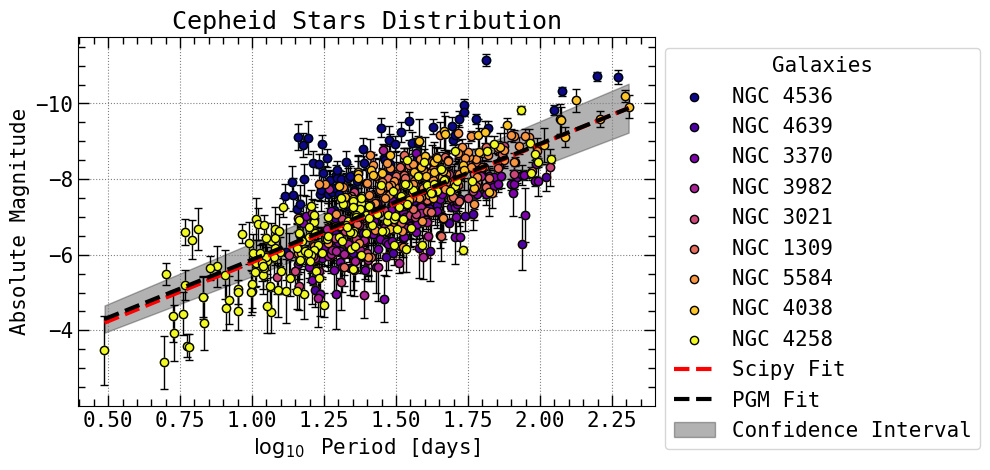

In [12]:
fig, ax = plt.subplots(figsize = (12, 5))

colormap_name = 'plasma'
unique_galaxies = df['gal'].unique()
colors = plt.get_cmap(colormap_name)(np.linspace(0, 1, len(unique_galaxies)))
#colors = plt.cm.tab10(np.linspace(0, 1, len(unique_galaxies)))

for color, gal in zip(colors, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.scatter(
        subset['logP'], subset['M'], color = color, s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax.errorbar(subset['logP'], subset['M'], yerr = subset['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)
    
ax.plot(xx, meanfunc(xx, a_opt, b_opt), ls = '--', lw = 3, color = 'r', label = 'Scipy Fit', zorder = 4)
plt.plot(logP_range, M_fit, ls = '--', lw = 3, color = 'k', label = 'PGM Fit', zorder = 5)
plt.fill_between(logP_range, m_fit_lower, m_fit_upper, color = 'k', alpha = 0.3, label = 'Confidence Interval')


ax.set_xlabel(r'$\log_{10}$ Period [days]')
ax.set_ylabel(r'Absolute Magnitude')
ax.set_title(r'Cepheid Stars Distribution')

ax.invert_yaxis()  
ax.legend(title = 'Galaxies', loc = 'upper left', bbox_to_anchor = (1, 1))
plt.tight_layout(rect = [0, 0, 0.85, 1])  

sm_plot()

---

## 3. Strategy

The hierarchical nature of this problem has left us with a large number of nuisance parameters, namely a true absolute magnitude for every one of the cepheids. The question now is: how are we going to deal with it?

There are a few possibilities:

### Sampling

We could take a brute force approach - just apply one of the general-purpose algorithms we've looked at and hope it works.

Alternatively, while it might not be obvious, this problem (a linear model with normal distributions everywhere) is fully conjugate, given the right choice of prior. We could therefore use a conjugate Gibbs sampling code specific to the linear/Gaussian case (it's common enough thay they exist) or a more general code that works out and takes advantage of any conjugate relations, given a model. (You could also work out and code up the conjugacies yourself, if you're into that kind of thing.) These are all still "brute-force" in the sense that they are sampling all the nuisance parameters, but we might hope for faster convergence than a more generic algorithm.

### Direct Integration

If some parameters truly are nuisance parameters, in the sense that we don't care what their posteriors are, then we'll ultimately marginalize over them anyway. Rather than sampling the full-dimensional parameter space and then looking only at the marginal distributions we care about, we always have the option of sampling only parameters we care about, and, while evaluating their posterior, doing integrals over the nuisance parameters in some other way. In other words, we should remember that obtaining samples of a parameter is only one method of integrating over it.

Whether it makes sense to go this route depends on the structure of the model (and how sophisticated you care to make your sampler). Somtimes, sampling the nuisance parameters just like the parameters of interest turns out to be the best option. Other times, direct integration is much more efficient. And, of course, "direct integration" could take many forms, depending on the integrand: an integral might be analytic, or it might be best accomplished by quadrature or by monte carlo integration. The dimensionality of the integration (in particular, whether it factors into one-dimensional, or at least low-dimensional, integrals) is something to consider.

$$
\diamond\qquad\diamond\qquad\diamond\qquad\diamond\qquad\diamond
$$

So, for this model, we try to write down the posterior for $a_{i}$, $b_{i}$ and $\sigma_{i}$, marginalized over the $M_{ij}$ parameters. If you're persistent, you should find that the integral is analytic, meaning that we can reduce the sampling problem to a computationally efficient posterior distribution over just $a_{i}$, $b_{i}$ and $\sigma_{i}$, at the expense of having to use our brains.

### 3.1 Mathematical Model

- #### Model Overview

1. $\log_{10}P_{j}=$ The log-period of the $j^{th}$ Cepheid ;
2. $m_{j}=$ The observed apparent magnitude of the $j^{th}$ Cepheid ;
3. $d_{L,j}=$ The luminosity distance to the $j^{th}$ Cepheid ;
4. $M_{ij}=$ The true absolute magnitude of the $j^{th}$ Cepheid ;
5. $a_{i},b_{i},\sigma_{i}=$ Parameters of interest (slope, intercept, and intrinsic scatter, respectively).

The model is given by

$$
M_{ij}=a_{i}+b_{i}\log_{10}P_{j}+\varepsilon_{j}\quad,\quad\varepsilon_{j}\thicksim\mathcal{N}\left(0,\sigma_{i}^{2}\right)\text{ }.
$$

The observed apparent magnitude is related to the true absolute magnitude by

$$
m_{j}=M_{ij}+5\log_{10}d_{L,j}+25+\delta_{j}\quad,\quad\delta_{j}\thicksim\mathcal{N}\left(0,\sigma_{\text{obs.},j}^{2}\right)\text{ }.
$$

- $\varepsilon_{j}=$ Intrisic scatter ;
- $\delta_{j}=$ Observational error .

- ### Likelihood Function

The likelihood for each Cepheid is

$$
\mathcal{L}_{j}\left(a_{i},b_{i},\sigma_{i},M_{ij}\right)=\frac{1}{\sqrt{2\pi\left(\sigma_{i}^{2}+\sigma_{\text{obs.},j}^{2}\right)}}\exp\left\{ -\frac{\left[m_{j}-\left(a_{i}+b_{i}\log_{10}P_{j}+5\log_{10}d_{L,j}+25\right)\right]^{2}}{2\left(\sigma_{i}^{2}+\sigma_{\text{obs.},j}^{2}\right)}\right\}  \text{ }.
$$

For all Cepheids

$$
\mathcal{L}\left(a_{i},b_{i},\sigma_{i},M_{ij}\right)=\prod_{j}\mathcal{L}_{j}\left(a_{i},b_{i},\sigma_{i},M_{ij}\right) \text{ }.
$$

- #### Posterior Distribution

The posterior distribution we are interested in is marginalized over the nuisance parameters $M_{ij}$

$$
\mathcal{P}\left(a_{i},b_{i},\sigma_{i}|\left\{ m_{j},\log_{10}P_{j},d_{L,j},\sigma_{\text{obs.},j}\right\} \right)=\underset{j}{\underbrace{\int\cdots\int}}\prod_{j}\mathcal{L}_{j}\left(a_{i},b_{i},\sigma_{i},M_{ij}\right)\mathcal{P}\left(M_{ij}\right)\text{ }\text{d}M_{ij} \text{ }.
$$

Since $M_{ij}$ are normally distributed, the marginalization over $M_{ij}$ can be done analytically, leading to an effective likelihood for $a_{i}$, $b_{i}$ and $\sigma_{i}$.

- #### Analytical Marginalization

Given the model's conjugacy (Gaussian likelihood and priors), the marginalization over $M_{ij}$ is analytic. The marginalized posterior is a normal distribution with an updated mean and variance. We focus on the posterior distribution over $a_{i}$, $b_{i}$ and $\sigma_{i}$ directly.

### 3.2 Schematic Representation

The process can be represented schematically as follows

1. **Model Specification**
> i. Define the linear model for $M_{ij}$ in terms of $a_{i}$ and $b_{i}$. \
> ii. Define the observed magnitude model $m_{j}$ in terms of $M_{ij}$, $d_{L,j}$, and other known quantities.

2. **Likelihood Construction**
> iii. Construct the joint likelihood $\mathcal{L}\left(a_{i},b_{i},\sigma_{i},M_{ij}\right)$

3. **Marginalization**
> iv. Integrate out $M_{ij}$ to obtain the marginalized posterior $\mathcal{P}\left(a_{i},b_{i},\sigma_{i}|\text{data}\right)$.

4. **Optimization or Sampling**
> v. Use an optimization or sampling method to estimate $a_{i}$, $b_{i}$, and $\sigma_{i}$ from the marginalized posterior.

### 3.3 Computational Implementation

- #### Define the marginalized log-likelihood function

In [13]:
def marginalized_log_likelihood(params, logP, m_obs, err_m, dL):
    a_i, b_i, sigma_i = params
    
    # Theoretical magnitude
    M_ij = a_i + b_i * logP
    m_ij = M_ij + 5 * np.log10(dL) + 25
    
    # Marginalized likelihood: integrating out M_ij
    sigma_total = np.sqrt(err_m**2 + sigma_i**2)
    likelihoods = norm.logpdf(m_obs, loc=m_ij, scale = sigma_total)
    
    # Return negative log-likelihood for minimization
    return -np.sum(likelihoods) 

- #### Implementation

In [14]:
# Initial guesses for parameters
initial_params = [0, 1, 0.1]

# Minimize the negative marginalized log-likelihood
result = minimize(marginalized_log_likelihood, initial_params, args = (logP, m_obs, err_m, dL), method = 'L-BFGS-B')

# Extract the optimized parameters
a_i_opt, b_i_opt, sigma_i_opt = result.x

# Compute the Hessian matrix (second derivatives of the log-likelihood)
hessian_inv = result.hess_inv.todense()  # Inverse of Hessian matrix

# Standard errors of the parameters are the square roots of the diagonal elements
standard_errors = np.sqrt(np.diag(hessian_inv))

- #### Results

In [19]:
print(f"Optimized a_i: {a_i_opt} ± {standard_errors[0]}")
print(f"Optimized b_i: {b_i_opt} ± {standard_errors[1]}")
print(f"Optimized sigma_i: {sigma_i_opt} ± {standard_errors[2]}")

Optimized a_i: -2.8041024392018623 ± 0.2827244443119007
Optimized b_i: -3.063083583619769 ± 0.15806565965643068
Optimized sigma_i: 0.7254236426215227 ± 0.02756171544859829


- #### Generate the fitted line 

In [20]:
logP_range = np.linspace(min(logP), max(logP), 100)
M_fit = a_i_opt + b_i_opt * logP_range
 # Assuming a constant dL for simplicity
m_fit = M_fit + 5 * np.log10(dL.mean()) + 25 

- #### Plotting

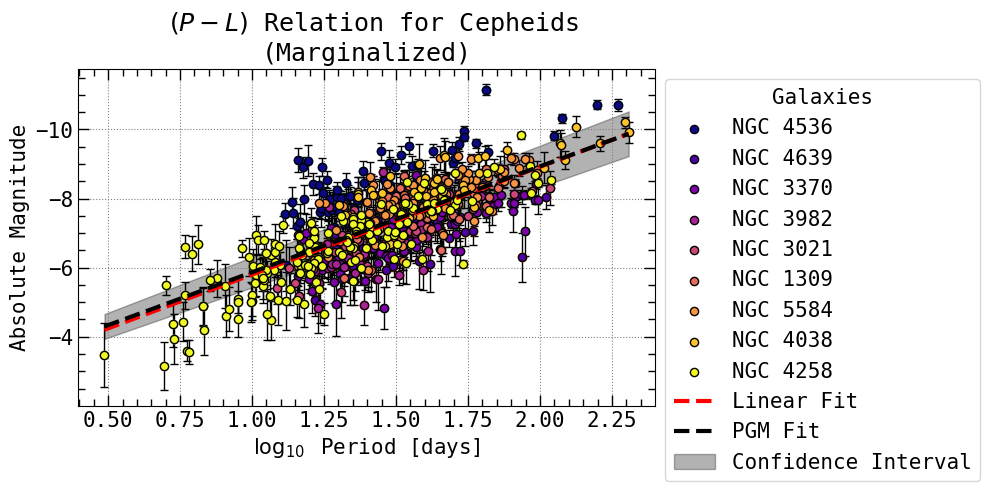

In [26]:
fig, ax = plt.subplots(figsize = (12, 5))

colormap_name = 'plasma'
unique_galaxies = df['gal'].unique()
colors = plt.get_cmap(colormap_name)(np.linspace(0, 1, len(unique_galaxies)))
#colors = plt.cm.tab10(np.linspace(0, 1, len(unique_galaxies)))

for color, gal in zip(colors, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.scatter(
        subset['logP'], subset['M'], color = color, s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax.errorbar(subset['logP'], subset['M'], yerr = subset['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)
    
ax.plot(xx, meanfunc(xx, a_opt, b_opt), ls = '--', lw = 3, color = 'r', label = 'Linear Fit', zorder = 4)
plt.plot(logP_range, M_fit, ls = '--', lw = 3, color = 'k', label = 'PGM Fit', zorder = 5)
plt.fill_between(logP_range, m_fit_lower, m_fit_upper, color = 'k', alpha = 0.3, label = 'Confidence Interval')


ax.set_xlabel(r'$\log_{10}$ Period [days]')
ax.set_ylabel(r'Absolute Magnitude')
ax.set_title(f' $(P-L)$ Relation for Cepheids\n(Marginalized)')

ax.invert_yaxis()  
ax.legend(title = 'Galaxies', loc = 'upper left', bbox_to_anchor = (1, 1))
plt.tight_layout(rect = [0, 0, 0.85, 1])  

sm_plot()

### Notes

#### 1. Optimization

The code uses ´scipy.optimize.minimize` to find the parameters $a_{i}$, $b_{i}$, and $\sigma_{i}$ that maximize the marginalized log-likelihood.

---

## 4. Obtain the Posterior

Sample the posterior $a_{i}$, $b_{i}$ and $\sigma_{i}$ for the one galaxy chosen above (i.e. a single $i$), and do the usual sanity checks and visualizations. Use "wide uniform" priors on $a$, $b$ and $\sigma$.

In the subsections below, you'll get to do this 3 different ways! First you'll apply a generic sampler to the brute-force and analytic integration methods. Then we'll walk through using a Gibbs sampling package.

Aside: a common trick to reduce the posterior correlation between the intercept and slope parameters of a line is to reparametrize the model as $a+bx\rightarrow a'+b\left(x-x_{0}\right)$, where the "pivot" $x_{0}$  is roughly the mean of x in th data.

It isn't strictly necessary to do this, but smaller correlations usually mean faster convergence. Of course, it's important to remeber this redefinition when visualizing/interpreting the results! Below, we'll adopt a pivot based on the `logP` of all the galaxies, to make our lives easier when working with the whole sample in the companion tutorial. This won't be the ideal pivot for any individual galaxy, but we'll still get most of the possible benefit of reducing the posterior correlation.

$$
\diamond\qquad\diamond\qquad\diamond\qquad\diamond\qquad\diamond
$$

### 4.1 Simplest Model

The likelihood for a single galaxy is

$$
p\left(M_{ij}|a_{i},b_{i},\sigma_{i}\right)=\mathcal{N}\left(M_{ij}|a_{i}+b_{i}\log_{10}P_{ij},\sigma_{i}^{2}\right)\text{ }.
$$

Given a dataset $\left\{\left(M_{ij},P_{ij}\right)\right\}$, the posterior distribution over the parameters $\{a_{i},b_{i},\sigma_{i}\}$ given the data is

$$
p\left(a_{i},b_{i}\sigma_{i}|\left\{ M_{ij},P_{ij}\right\} \right)\propto p\left(a_{i}\right)p\left(b_{i}\right)p\left(\sigma_{i}\right)\prod_{j}p\left(M_{ij}|a_{i},b_{i},\sigma_{i}\right)\text{ }.
$$

Assuming wide uniform priors for $a_{i}$, $b_{i}$, and $\sigma_{i}$, we can directly write down the posterior distribution for $a_{i}$, $b_{i}$, and $\sigma_{i}$ and then sample from it.

### 4.2 Computational Implementation

- #### Functions Definitions

In [27]:
# Define the likelihood function
def log_likelihood(theta, logP, M):
    a, b, sigma = theta
    model = a + b * logP
    sigma2 = sigma ** 2
    return -0.5 * np.sum((M - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

# Define the prior (wide uniform priors)
def log_prior(theta):
    a, b, sigma = theta
    if -10 < a < 10 and -10 < b < 10 and 0 < sigma < 10:
        return 0.0
    return -np.inf

# Define the posterior probability
def log_posterior(theta, logP, M):
    lp = log_prior(theta)
    if np.isfinite(lp):
        return lp + log_likelihood(theta, logP, M)
    return -np.inf

- #### Implementation

In [44]:
# Initial guess for the parameters (to be adjusted as needed)
guess = {'a': 0.5, 'b': -2.0, 'sigma': 0.1}
guessvec = [guess[p] for p in ['a', 'b', 'sigma']]

# Setting up the MCMC sampler
ndim = 3              # Number of parameters (a, b, sigma)
nwalkers = 100        # Number of walkers
nsteps = 10_000       # Number of steps

# Initial positions of the walkers
pos = [guessvec + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

- #### MCMC-MH Run

In [45]:
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args = (logP, M))

# Run the MCMC chain
sampler.run_mcmc(pos, nsteps, progress = True)

# Extract the samples
samples = sampler.get_chain(discard = 100, thin = 10, flat = True)

100%|████████████████████████████████| 10000/10000 [11:03<00:00, 15.07it/s]


- #### Plotting

> 1. **Sanity Checks**
>> The trace plots allow us to check for proper convergence of the MCMC chains. If the chains mix well and have stabilized, this indicates that the sampling process is performing correctly

Text(0.5, 0, 'Step Number')

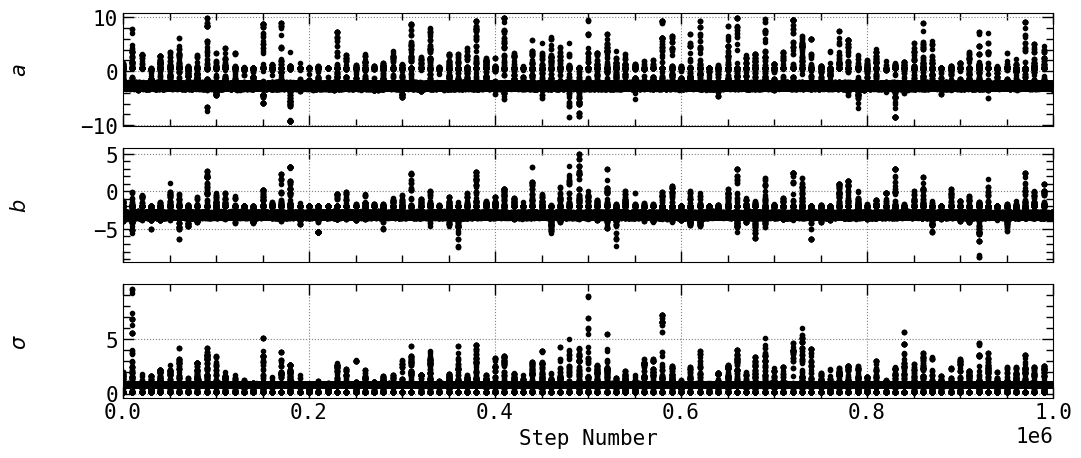

In [46]:
##############
# TRACE PLOT #
##############
fig, axes = plt.subplots(ndim, figsize = (12,5), sharex = True)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
labels = ['$a$', '$b$','$\sigma$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i,], ".", color = 'k')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    sm_plot_mod(ax)
axes[-1].set_xlabel("Step Number")

> 2. **Corner Plot :** 
>> This visualization shows the joint posterior distributions of the parameters $a_{i}$, $b_{i}$, and $\sigma_{i}$. It helps to assess correlations between parameters and understand the uncertainty in our estimates.

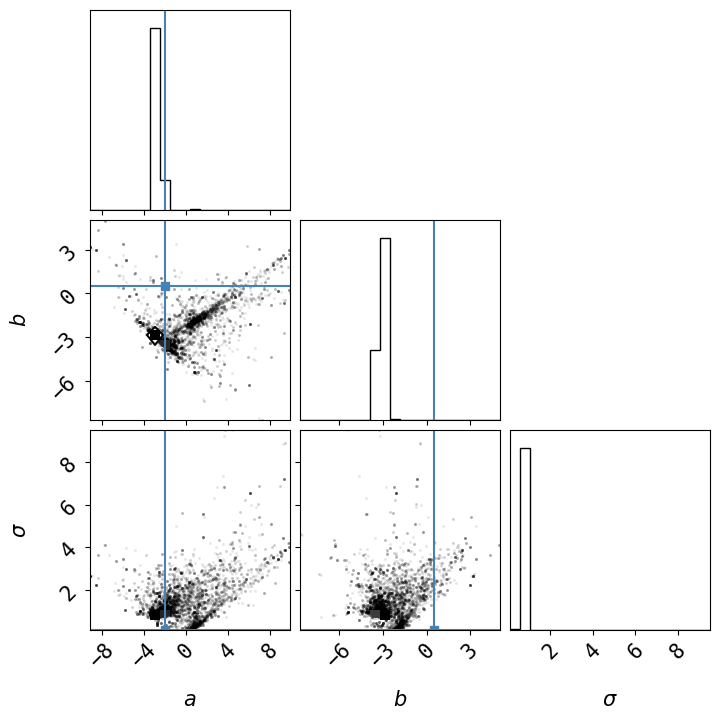

In [50]:
###############
# CORNER PLOT #
###############
fig = corner.corner(samples, labels = ['$a$', '$b$', '$\sigma$'], 
                    truths = [guess['a'], guess['b'], guess['sigma']], bins = 20)

### 4.3 More Refined Model

Let's adjust the mathematical model and the code to include the absolute magnitude $M_{1}$ as a parameter to be estimated. This means that instead of estimating only $a$, $b$, and $\sigma$, we'll also estimate $M_{1}$,  which represents the true absolute magnitude for the Cepheid.

### Modified Mathematical Model

The modified model is
$$
M_{ij}=M_{1}+a\cdot\log_{10}P_{ij}+b+\varepsilon_{ij}\text{ }.
$$

The likelihood for a single galaxy with $n$ Cepheids is
$$
p\left(M_{ij}|M_{1},a,b,\sigma\right)=\mathcal{N}\left(M_{ij}|M_{1}+a\cdot\log_{10}P_{ij}+b,\sigma^{2}\right)\text{ }.
$$

The posterior distribution over the parameters $M_{1}$, $a$, $b$, and $\sigma$ given the data is
$$
p\left(M_{1},a,b,\sigma|\left\{ M_{ij},P_{ij}\right\} \right)\propto p\left(M_{1}\right)p\left(a\right)p\left(b\right)p\left(\sigma\right)\prod_{j}p\left(M_{ij}|M_{1},a,b,\sigma\right)\text{ }.
$$

Assuming wide uniform priors for $M_{1}$, $a$, $b$, and $\sigma$, we can write down the posterior distribution and sample from it.

### Computational Implementation

- #### Functions Definitions

In [48]:
# Define the likelihood function
def log_likelihood(theta, logP, M):
    M_1, a, b, sigma = theta
    model = M_1 + a * logP + b
    sigma2 = sigma ** 2
    return -0.5 * np.sum((M - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

# Define the prior (wide uniform priors)
def log_prior(theta):
    M_1, a, b, sigma = theta
    if -10 < M_1 < 10 and -10 < a < 10 and -10 < b < 10 and 0 < sigma < 10:
        return 0.0
    return -np.inf

# Define the posterior probability
def log_posterior(theta, logP, M):
    lp = log_prior(theta)
    if np.isfinite(lp):
        return lp + log_likelihood(theta, logP, M)
    return -np.inf

- #### Implementation

In [52]:
# Initial guess for the parameters (adjust as needed)
guess = {'M_1': -5, 'a': -2.0, 'b': 0.5, 'sigma': 0.1}
guessvec = [guess[p] for p in ['M_1', 'a', 'b', 'sigma']]

# Setting up the MCMC sampler
ndim = 4               # Number of parameters (M_1, a, b, sigma)
nwalkers = 100         # Number of walkers
nsteps = 10_000       # Number of steps

# Initial positions of the walkers
pos = [guessvec + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

- #### MCMC-MH Run

In [53]:
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args = (logP, M))

# Run the MCMC chain
sampler.run_mcmc(pos, nsteps, progress = True)

# Extract the samples
samples = sampler.get_chain(discard = 100, thin = 10, flat = True)

100%|████████████████████████████████| 10000/10000 [10:36<00:00, 15.71it/s]


- #### Plotting

Text(0.5, 0, 'Step Number')

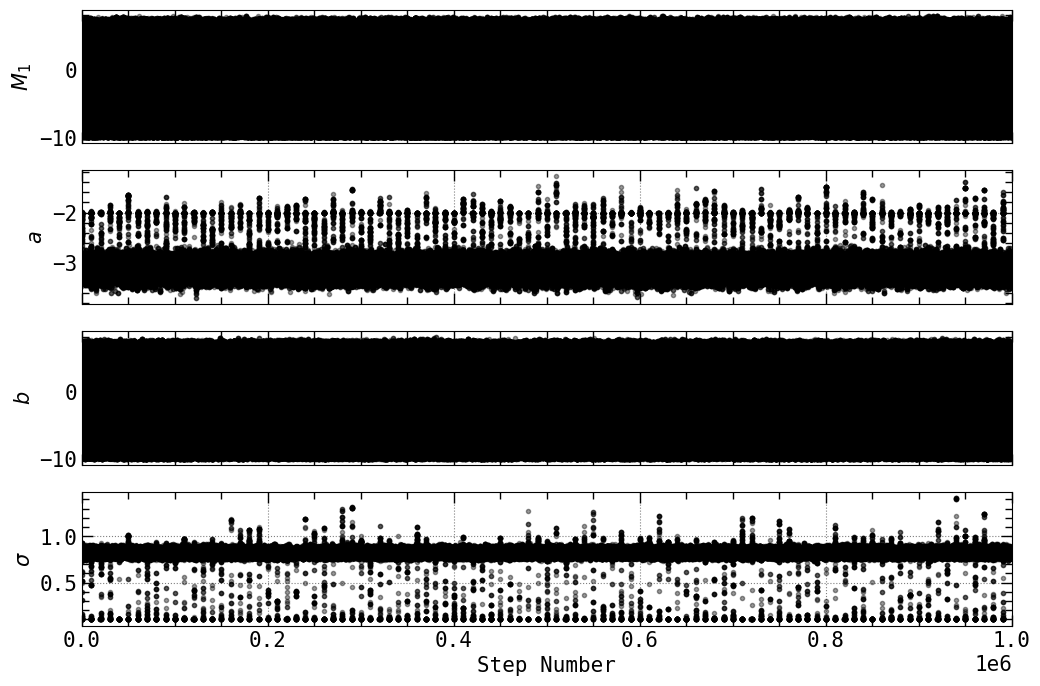

In [59]:
##############
# TRACE PLOT #
##############
fig, axes = plt.subplots(ndim, figsize = (12,8), sharex = True)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
labels = ['$M_1$', '$a$', '$b$','$\sigma$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i,], ".", color = 'k', alpha = 0.4)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    sm_plot_mod(ax)
axes[-1].set_xlabel("Step Number")

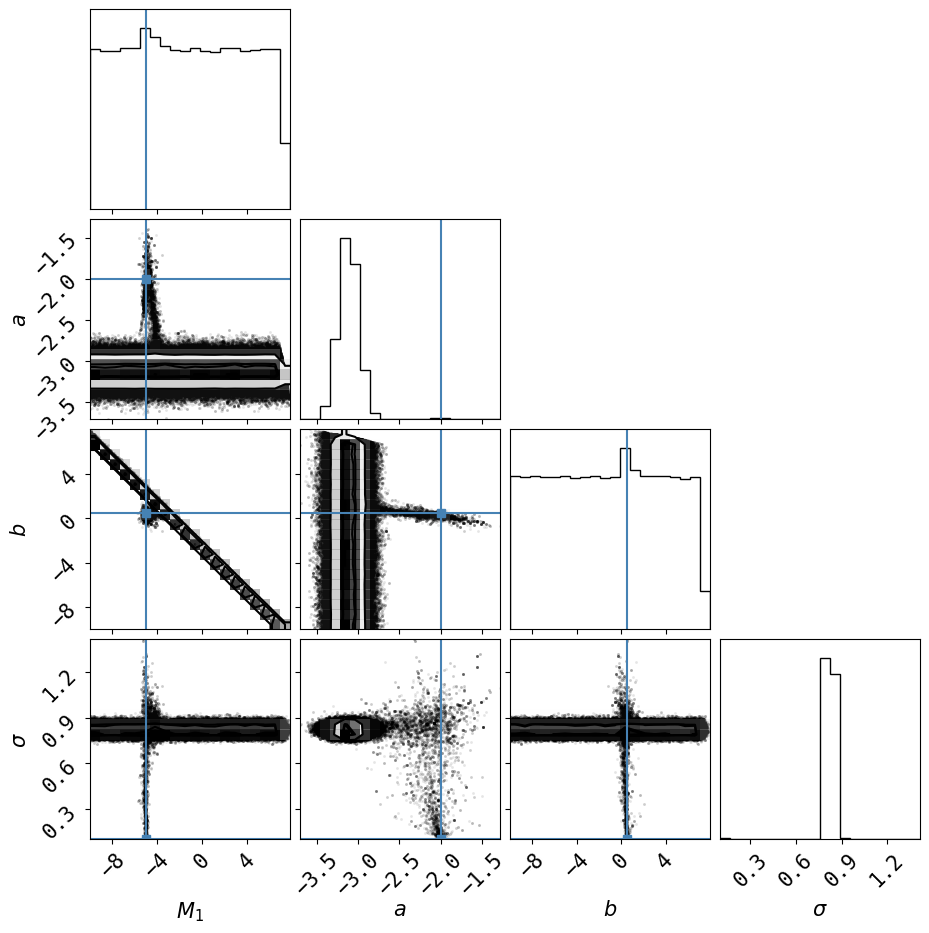

In [58]:
###############
# CORNER PLOT #
###############
fig = corner.corner(samples, labels = ['$M_1$', '$a$', '$b$', '$\sigma$'], 
                    truths = [guess['M_1'], guess['a'], guess['b'], guess['sigma']], bins = 20)

plt.savefig('Plots/corner_modified_model.png', dpi = 400)

### Next Steps

- The next step now is to try to fit a multiple linear regression using `emcee` taking metallicity into account. In symbols, the ideia is to fit an equation of the type:

$$
\boxed{M=a_{i}+b_{i}\log_{10}\left({P}\right)+c_{i}\log{\left[\text{O/H}\right]}\quad,\quad i\equiv\text{Host Galaxies}}
$$

$$
\boxed{\text{Wendell Stopped Here!}}
$$

---

## 5. João's Part

$$
\boxed{\text{João Started Here!}}
$$